# Introduction

![Propulsion Engine](./input/engine.png)

In this notebook, we investigate what cause a fault in the high-pressure compressor (HPC) unit of aero-propulsion engine. Furthermore, we use these sensors to predict its remaining useful life.

# Part 1: Load data

Let's load some useful Python libraries:
1. numpy: structural data types
2. pandas: data loading and manipulation
3. matplotlib, sns: data visualization
4. sklearn: data analytics algorithms

In [3]:
#%% load library
import gc
#import resource
import rope
#import operator
import numpy as np
import pandas as pd

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", color_codes=True)

#import xgboost as xgb
#from xgboost.sklearn import XGBClassifier

from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import normalize

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LassoCV

import warnings
warnings.filterwarnings("ignore")

We have data from 4 machine fleets. Here we examine the first one FD001.

In [12]:
#%% Load data
print('Start loading data ...')

# Load and combine training data
#train_1 = pd.read_csv('./input/train_FD001.txt', delim_whitespace=True, header=None)
#train_2 = pd.read_csv('./input/train_FD002.txt', delim_whitespace=True, header=None)
train_3 = pd.read_csv('./input/train_FD003.txt', delim_whitespace=True, header=None)
#train_4 = pd.read_csv('./input/train_FD004.txt', delim_whitespace=True, header=None)

train = train_3

Start loading data ...


In [13]:
# Check dimension
print('Dimension of train_FD001: ', train.shape)

Dimension of train_FD001:  (24720, 26)


In [14]:
# Assign column headers: id, te, (time evolutions) os1, os2, os3, (operational settings) s1, s2, ..., s21 (sensors)
sensor_name = ['s'+ str(i) for i in range(1,22)]
train.columns = ['id', 'te', 'os1', 'os2', 'os3'] + sensor_name

### Question 1:
We have training and testing data from 4 machine fleets (one fleet is one group of machines), FD001 - FD004. From your opinion, which scenarios should we build a model for all machine fleet, or build individual models for each fleet?

# Part 2: Signal Smoothing

Number of cycles per machine:  100


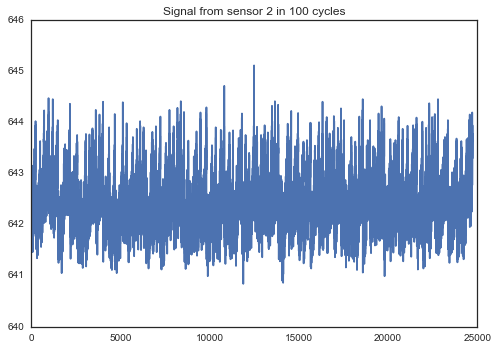

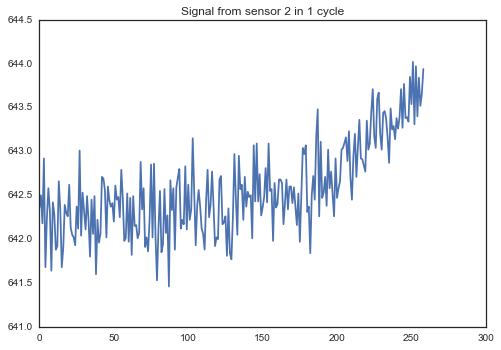

In [15]:
print('Number of cycles per machine: ', train['id'].unique().size)
s2_100_cycle = train.ix[:,'s2']
s2_1_cycle = train.ix[train['id']==1,'s2']
plt.figure(1)
plt.plot(s2_100_cycle)
plt.title('Signal from sensor 2 in 100 cycles')
plt.figure(2)
plt.plot(s2_1_cycle)
plt.title('Signal from sensor 2 in 1 cycle')

As you can see, there is some white noise in the signal. Unless there is useful information on structural noise, such as the noise grows bigger near the failure, we should clean the signal.

[      nan       nan       nan       nan       nan  642.28    642.245
  642.201   642.175   642.195   642.2     642.138   642.1075  642.144
  642.169   642.178   642.2075  642.2265  642.201   642.1485  642.1625
  642.208   642.25    642.268   642.2685  642.267   642.251   642.272
  642.3035  642.3065  642.304   642.305   642.276   642.228   642.1905
  642.157   642.1365  642.145   642.18    642.242   642.2585  642.264
  642.2885  642.3245  642.3725  642.394   642.4335  642.448   642.4245
  642.3985  642.4215  642.4535  642.424   642.383   642.3705  642.3645
  642.346   642.3075  642.2765  642.272   642.2355  642.181   642.1625
  642.2105  642.245   642.2665  642.269   642.251   642.2295  642.2015
  642.2395  642.2745  642.3145  642.3115  642.2285  642.1655  642.175
  642.1985  642.194   642.2155  642.194   642.1675  642.11    642.072
  642.144   642.2065  642.1955  642.199   642.274   642.3235  642.3375
  642.3375  642.3705  642.414   642.411   642.402   642.421   642.4255
  642.4355  

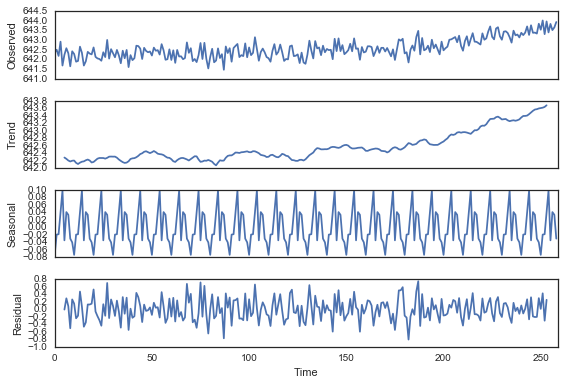

In [16]:
# Smoothing technique: lowpass
"""
from scipy import fftpack

# plot FFT graph
sample_freq = fftpack.fftfreq(sig.size, d=1)
sig_fft = fftpack.fft(s2_1_cycle)
pidxs = np.where(sample_freq > 0)
freqs = sample_freq[pidxs]
power = np.abs(sig_fft)[pidxs]
plt.figure(1)
plt.plot(power)
print(power.size)

# calculate 1st frequency mode and filter other high frequency noise
freq = freqs[power.argmax()]
sig_fft[np.abs(sample_freq) > freq*10] = 0

plt.figure(2)
plt.plot(s2_1_cycle)
plt.figure(3)
s2_1_cycle_smooth = fftpack.ifft(sig_fft)
plt.plot(s2_1_cycle_smooth)
"""

# Smooth technique: decomposition

from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(s2_1_cycle.values, freq=10)
print(res.trend)
resplot = res.plot()


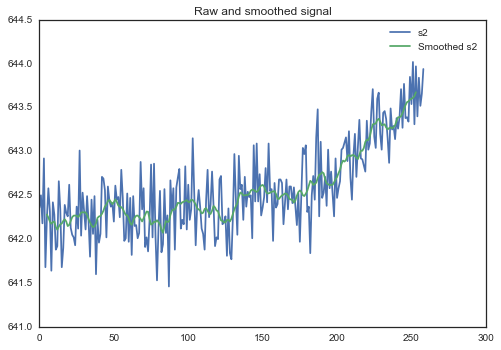

In [17]:
# access individual series by
trend = res.trend
seasonal = res.seasonal
residual = res.resid

line_1, = plt.plot(s2_1_cycle, label='line 1')
line_2, = plt.plot(trend, label='line 2')
plt.title('Raw and smoothed signal')
plt.legend([line_1, line_2], ['s2', 'Smoothed s2'])

### Question 2: 
We should smooth out the sensor signals to remove measurement noises. Should we do that for operational settings too?

Great! We have a method to clean white noise. Now it's time to apply to all the signals (columns in the data frame).

In [20]:
# Apply decomposition for all columns at EACH cycle id.
train = train_3

def f(col):
    smooth_col = seasonal_decompose(col.values, freq=10).trend
    return smooth_col
transformed = train.drop(['te', 'os1', 'os2', 'os3'], axis=1).groupby('id').transform(f)
transformed['id'] = train['id']  # add back because transform will throw away 'id'

# overwrite smooth signals back to train Dataframe
df_1 = train[['id', 'te', 'os1', 'os2', 'os3']]
df_2 = transformed.groupby('id').ffill().bfill().drop('id', axis=1)
train = pd.concat([df_1, df_2], axis=1)

# Part 3: Create target - Remaining Useful Life (RUL)
As discussed in the paper "*Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation*
Abhinav Saxena, Kai Goebel,
Don Simon, Neil Eklund" on how they generated the data, the health index of a machine decelerates exponentially near the failure in terms of time. 

From the time evolution, we need to construct a target signal for our model to predict. We have two options: 
1. Remaining time, which decreases linearly. 
2. Decelerating health index, which decreases exponentially.

### Question 3:
Could you give a short discussion on the advantage and disadvantage of each?

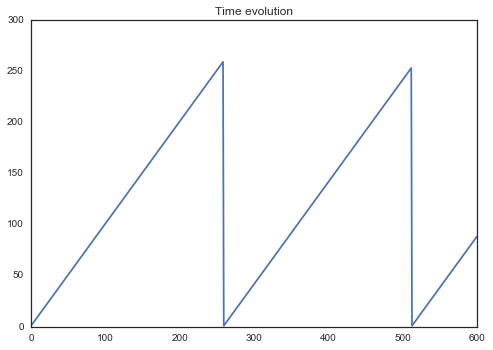

In [21]:
# Plot out the time evolution
plt.plot(train['te'][1:600])
plt.title('Time evolution')

## Option 1 - Linear target

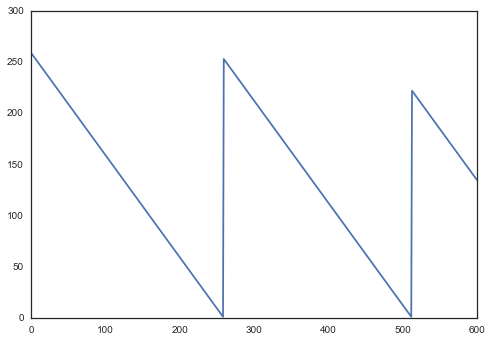

In [22]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1]  

train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

# Part 4: Investigate degenerating sensors

In [23]:
# prepare the data
# then split them into train and test sets
y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = pd.DataFrame(normalize(train[features], axis=0))
X.columns = features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

Optimal value:  2.83821633045e-06
[  8.80476940e+01   3.97987841e+01  -0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -1.76063618e+06   1.16505403e+05   0.00000000e+00
   0.00000000e+00  -1.46582717e+05  -0.00000000e+00  -3.05723679e+05
   5.79697850e+05   0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -2.03446881e+05   3.60249198e+05   0.00000000e+00  -1.64739101e+06
  -0.00000000e+00  -0.00000000e+00   9.60566740e+04   2.05278530e+05]
Useful sensors to predict RUL:  Index(['os1', 'os2', 's3', 's4', 's7', 's9', 's10', 's14', 's15', 's17', 's20',
       's21'],
      dtype='object')


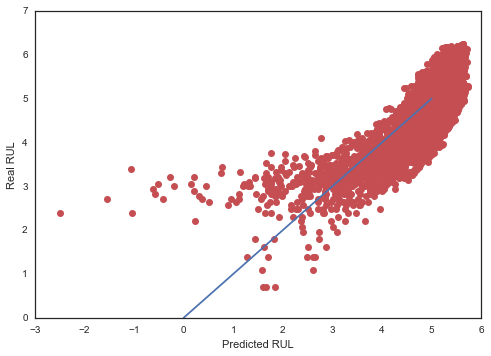

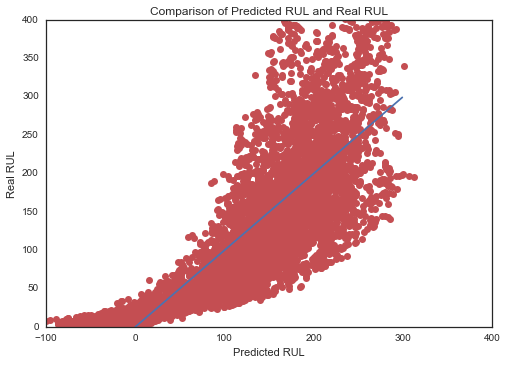

In [24]:
# try Lasso
ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(1)
plt.plot(np.log(ls.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))  # plot the line y = x of perfect prediction


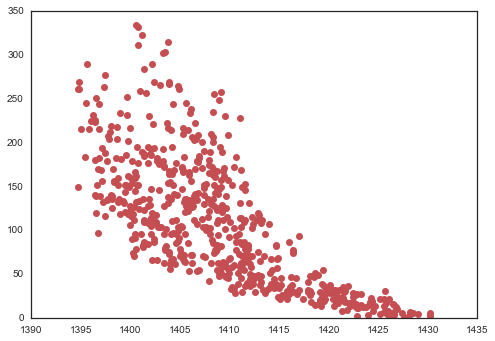

In [101]:
# try plotting signals to convince yourself that these important sensors really have correlation with our target
plt.plot(X_train['s4'][1:600], y_train[1:600], 'ro')

## Option 2 - Exponential target

Optimal value:  0.0126050797047
[ -0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -4.12879485e-02  -5.27801712e-02   0.00000000e+00
   0.00000000e+00  -1.80489945e-02  -0.00000000e+00  -9.50214640e-03
  -0.00000000e+00  -0.00000000e+00  -2.93972140e-05  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -2.23777580e-02
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]
Useful sensors to predict RUL:  Index(['s3', 's4', 's7', 's9', 's12', 's17'], dtype='object')


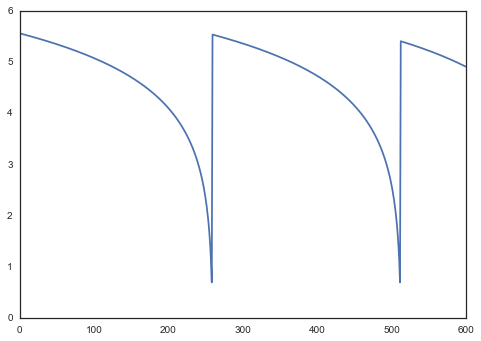

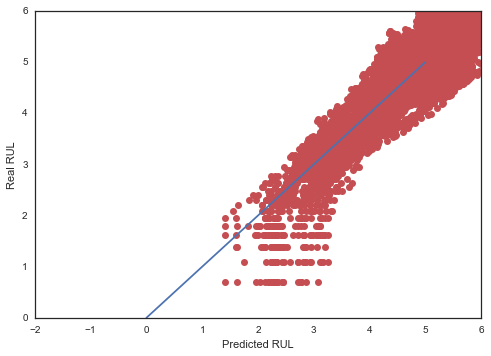

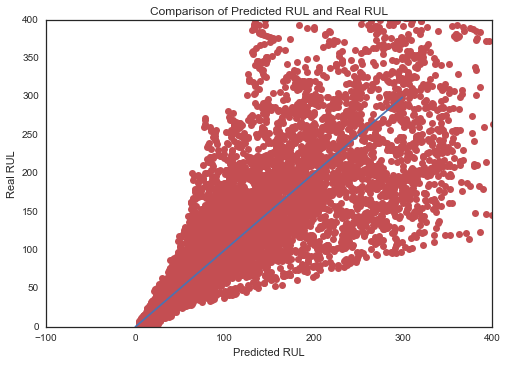

In [26]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Lasso
from sklearn.linear_model import LassoCV

ls = LassoCV(random_state=12)
ls = ls.fit(X_train, y_train)

#print('List of tried parameter values: ', ls.alphas_)
print('Optimal value: ', ls.alpha_)
print(ls.coef_)
print('Useful sensors to predict RUL: ', X_train.columns[abs(ls.coef_) > 1e-6])

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(ls.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(ls.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.axis([-100, 400, 0, 400])
plt.plot(range(300), range(300))

# Part 5: Trees

## Option 1 - Linear target

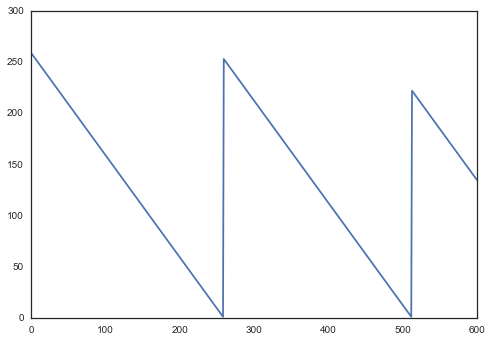

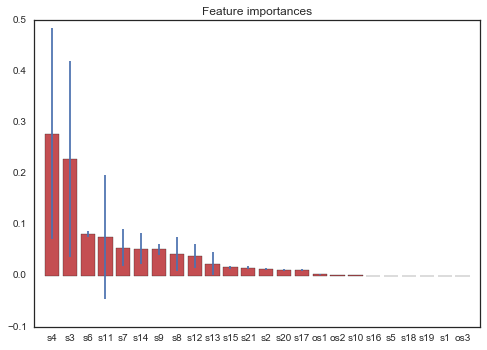

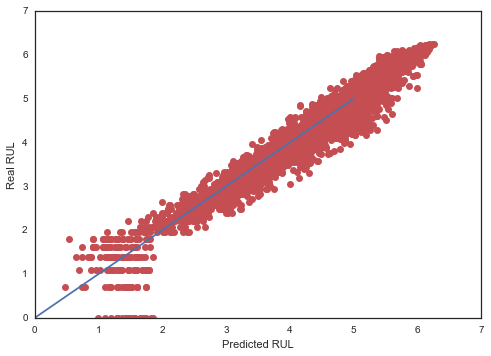

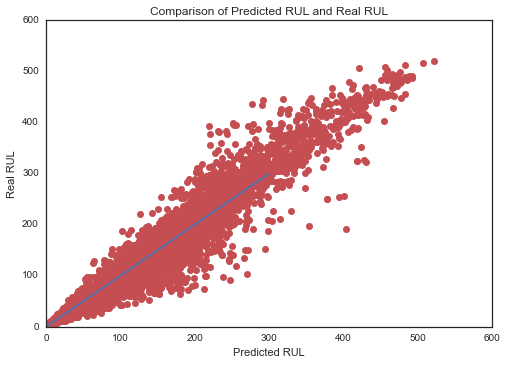

In [28]:
def f1(col):
    # Option 1: Reverse the time evolution, where remaining time of a machine is 1 at the failure.
    return col[::-1] 

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Random Forest
rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# Feature importance
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices])
plt.xlim([-1, X_train.shape[1]])
plt.show()


# compare predict RUL and real RUL
plt.figure(2)
plt.plot(np.log(rf.predict(X_test)), np.log(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))

plt.figure(3)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))

### Question 4:
Which sensors can show the degradation of the propulsion engines? What is the physically meaning of these sensors? (Hint: refer to the readme file in the data)

## Option 2 - Exponential target

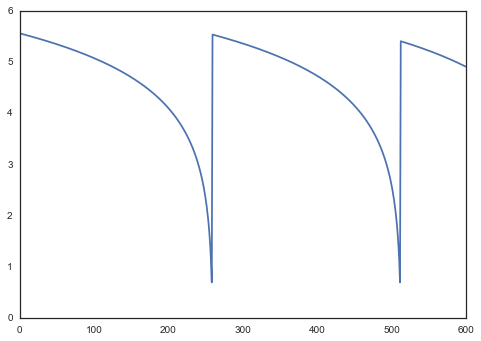

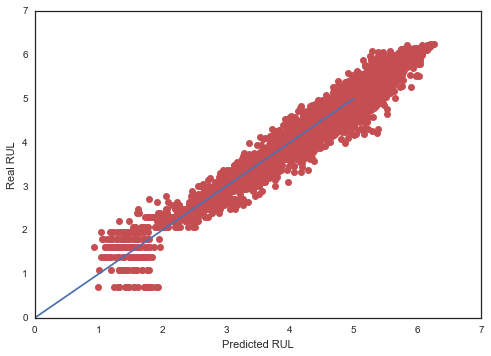

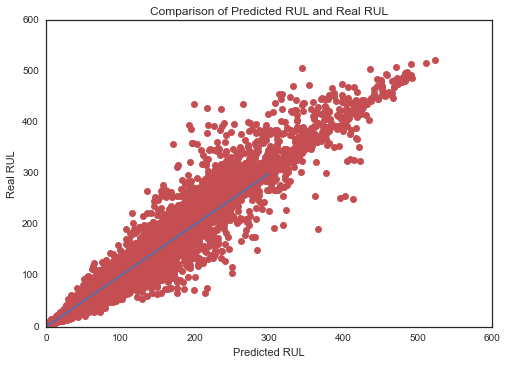

In [30]:
# Now let's try do log transformation to create exponential-degenerating RUL

def f1(col):
    # Option 2: transform time evolution into exponential-degenerating remaining health index 
    return np.log(col[::-1] + 1)  

plt.figure(1)
train['rul'] = train[['id', 'te']].groupby('id').transform(f1)
plt.plot(train.rul[1:600])

y = train['rul']
features = train.columns.drop(['id', 'te', 'rul'])
X = train[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# try Lasso
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=12)
rf = rf.fit(X_train, y_train)

# compare predict RUL and real RUL
plt.figure(2)
plt.plot(rf.predict(X_test), y_test, 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.plot(range(6), range(6))
#plt.axis([-2, 6, 0, 6])

plt.figure(3)
plt.plot(np.exp(rf.predict(X_test)), np.exp(y_test), 'ro')
plt.xlabel('Predicted RUL')
plt.ylabel('Real RUL')
plt.title('Comparison of Predicted RUL and Real RUL')
plt.plot(range(300), range(300))

#### REMARK
It is clear that Random Forest doesn't care about the transformation, as long as the transformation function is monotonically increase (x >= y equivalent to f(x) >= f(y), in this case f(x) = log(x)).

Furthermore, our raw, un-tuned nonlinear model Random Forest beats the CV_tuned optimal linear Lasso.

### Grand Question:
Run the experiment again for the machine fleet FD003 and observe the result. Note that FD003 is more complicated than FD001 because while FD001 has only one failure mode (HPC), either HPC degeneration or Fan degeneration can cause FD003 to fail.